<a href="https://colab.research.google.com/github/goralex02/Data_Processing_and_Machine_Learning/blob/main/PyTorch_regression_fully_connected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Регрессия с PyTorch. Полносвязные нейронные сети.

### О задании

В этом задании нам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd).

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [3]:
set_random_seed(42)

In [4]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-12-06 17:33:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [    <=>             ] 201.24M  4.06MB/s    in 28s     

2024-12-06 17:33:32 (7.23 MB/s) - ‘data.txt.zip’ saved [211011981]



## Разведочный анализ данных

Посмотрим информацию о датасете.

In [5]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       515345 non-null  int64  
 1   1       515345 non-null  float64
 2   2       515345 non-null  float64
 3   3       515345 non-null  float64
 4   4       515345 non-null  float64
 5   5       515345 non-null  float64
 6   6       515345 non-null  float64
 7   7       515345 non-null  float64
 8   8       515345 non-null  float64
 9   9       515345 non-null  float64
 10  10      515345 non-null  float64
 11  11      515345 non-null  float64
 12  12      515345 non-null  float64
 13  13      515345 non-null  float64
 14  14      515345 non-null  float64
 15  15      515345 non-null  float64
 16  16      515345 non-null  float64
 17  17      515345 non-null  float64
 18  18      515345 non-null  float64
 19  19      515345 non-null  float64
 20  20      515345 non-null  float64
 21  21      51

Посмотрим, есть ли нечисловые значения или пропуски.

In [7]:
print(np.any(df.dtypes == 'object'))
print(df.isna().any().any())

False
False


Посмотрим на описание наших признаков. Точно надо масштабировать.

In [8]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,...,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,...,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,...,-1.812650,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210
50%,2002.000000,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,...,9.171850,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050
75%,2006.000000,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,...,26.274480,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


Посмотрим на распределение таргета.

0
1922        6
1924        5
1925        7
1926       19
1927       42
        ...  
2007    39404
2008    34760
2009    31038
2010     9396
2011        1
Name: count, Length: 89, dtype: int64


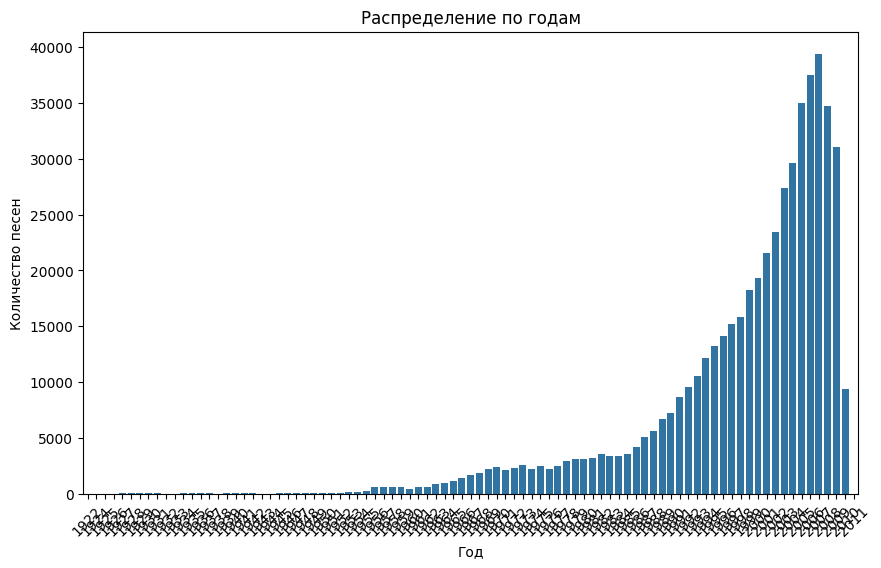

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

year_counts = df[0].value_counts().sort_index()
print(year_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=year_counts.index, y=year_counts.values)
plt.title('Распределение по годам')
plt.xlabel('Год')
plt.ylabel('Количество песен')
plt.xticks(rotation=45)
plt.show()

Распределение неравноемерное, но в принципе сойдет. Разделим данные на тренировочные и тестовые.

In [10]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Подготовка данных и бейзлайн

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучим Ridge регрессию из sklearn. Кроме того, посчитаем качество при наилучшем константном прогнозе.


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape)
print(X_test.shape)

(463715, 90)
(51630, 90)


In [13]:
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(X_train, y_train)

Ridge()

In [14]:
from sklearn.metrics import mean_squared_error
rmse_for_model = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print('RMSE for Ridge =', rmse_for_model)

RMSE for Ridge = 9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [15]:
best_rmse_metric = np.sqrt(mean_squared_error(y_test, np.array([y_train.mean()] * y_test.shape[0])))
print('Mean RMSE for Ridge =', best_rmse_metric)

Mean RMSE for Ridge = 10.85246390513634


## Нейронная сеть



Воспользуемся классами и функциями PyTorch, создадим датасет, модель и даталоадеры для удобства.

In [16]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

In [17]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.linear = nn.Linear(X_train.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.linear2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)

        self.linear3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)

        self.linear4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.bn2(x)
        x = self.relu(x)
        #x = self.dropout(x)

        x = self.linear3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.linear4(x)
        return x

In [18]:
train_set = MyDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = MyDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)
model = MyModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

Напишем код для обучения модели.

In [19]:
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    train_losses = []
    val_losses = []
    best_params = {
        'loss': float('inf'),
        'epoch': -1,
    }
    num_epochs = 30
    for epoch in range(num_epochs):
      train_loss_epoch = []
      model.train()
      for X_train, y_train in tqdm(train_loader):
        y_pred = model(X_train).squeeze(1)
        loss = torch.sqrt(criterion(y_pred, y_train)) #torch.sqrt(criterion(y_pred, y_train))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_epoch.append(loss.item())
      train_losses.append(np.mean(train_loss_epoch))

      val_loss_epoch = []
      model.eval()
      with torch.no_grad():
        for X_test, y_test in tqdm(test_loader):
          y_pred = model(X_test).squeeze(1)
          loss = torch.sqrt(criterion(y_pred, y_test)) #torch.sqrt(criterion(y_pred, y_test))
          val_loss_epoch.append(loss.item())
      val_losses.append(np.mean(val_loss_epoch))

      if best_params['loss'] > np.mean(val_loss_epoch):
        best_params['loss'] = np.mean(val_loss_epoch)
        best_params['epoch'] = epoch
        torch.save(model.state_dict(), 'best_model.pth')

      print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Test Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return model


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval()
    y_pred = []
    with torch.no_grad():
      for X_test, y_test in tqdm(test_loader):
        y_pred.append(model(X_test).squeeze(1))
    predicts = torch.cat(y_pred, dim=0)
    return predicts


Обучим модель.

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 1, Train Loss: 1031.3211, Val Loss: 8.8169


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 2, Train Loss: 9.1950, Val Loss: 8.3409


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 3, Train Loss: 8.9922, Val Loss: 8.0445


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 4, Train Loss: 8.8926, Val Loss: 8.3031


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 5, Train Loss: 8.8339, Val Loss: 7.9528


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 6, Train Loss: 8.7955, Val Loss: 7.8895


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 7, Train Loss: 8.7624, Val Loss: 7.8872


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 8, Train Loss: 8.7345, Val Loss: 7.8609


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 9, Train Loss: 8.7065, Val Loss: 8.9015


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 10, Train Loss: 8.6933, Val Loss: 7.9034


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 11, Train Loss: 8.6725, Val Loss: 7.9150


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 12, Train Loss: 8.6591, Val Loss: 8.2725


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 13, Train Loss: 8.6425, Val Loss: 7.8510


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 14, Train Loss: 8.6297, Val Loss: 7.8175


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 15, Train Loss: 8.6148, Val Loss: 7.8544


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 16, Train Loss: 8.6037, Val Loss: 8.0006


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 17, Train Loss: 8.5916, Val Loss: 8.0467


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 18, Train Loss: 8.5794, Val Loss: 7.8677


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 19, Train Loss: 8.5667, Val Loss: 8.0336


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 20, Train Loss: 8.5609, Val Loss: 7.7959


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 21, Train Loss: 8.5551, Val Loss: 7.8759


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 22, Train Loss: 8.5419, Val Loss: 8.1882


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 23, Train Loss: 8.5276, Val Loss: 7.8288


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 24, Train Loss: 8.5304, Val Loss: 7.8933


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 25, Train Loss: 8.5066, Val Loss: 7.8880


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 26, Train Loss: 8.5014, Val Loss: 8.4714


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 27, Train Loss: 8.5026, Val Loss: 7.8416


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 28, Train Loss: 8.4911, Val Loss: 8.3092


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 29, Train Loss: 8.4857, Val Loss: 7.8668


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 30, Train Loss: 8.4788, Val Loss: 8.0052


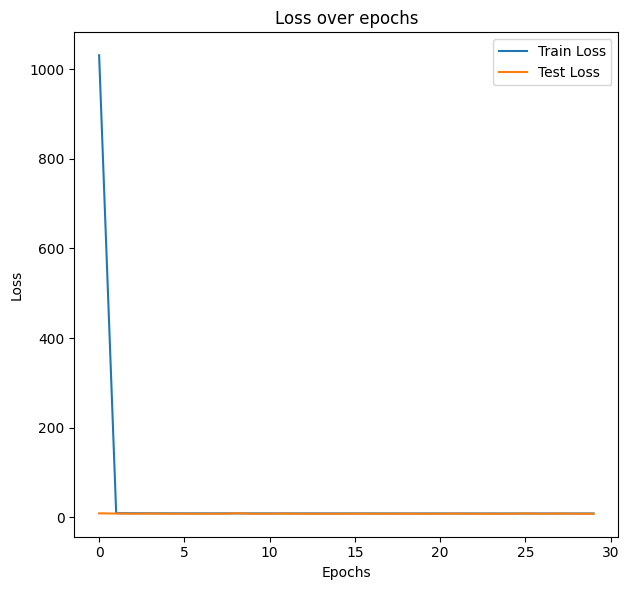

MyModel(
  (linear): Linear(in_features=90, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [20]:
train(model, optimizer, criterion, train_loader, test_loader)

Воспользуемся ассертом для проверки соответствия размерности

In [21]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

  0%|          | 0/807 [00:00<?, ?it/s]

## Вывод

Полносвязная нейронная сеть отработала значительно лучше Ridge регрессии, но времени на обучение понадобилось больше. Также пришлось поэкспериментировать с гиперпараметрами и структурой модели. Ошибка определения года составляет около 8 лет.